## Good results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo


def run_one_method(method, temperatures, Lx, Ly, J, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = IsingLattice(Lx, Ly, J=J)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)
        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        # errors with correlated samples: sigma ≈ sqrt( var * 2*tau / N )
        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        # susceptibility from fluctuations (Z2-symmetric definition)
        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

# ---------- parameters ----------
temperatures = np.linspace(1.5, 3.0, 31)
Lx = 10; Ly = 10              # 8×8 is very noisy near Tc; 32×32 is a good start
J_fm = -1.0                   # IMPORTANT: negative for ferro with your ΔE formula

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, Lx, Ly, 1, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, Lx, Ly, J_fm, warmup_m, steps_m)



Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3475.93it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3485.19it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4062.04it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4218.85it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5797.08it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5431.69it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5996.23it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4811.43it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4832.43it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5245.35it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6119.94it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5444.02it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6112.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5610.76it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6531.35it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5644.07it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5579.91it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5775.55it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6642.55it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5793.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5937.49it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5834.28it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6839.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5944.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7172.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6286.10it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6580.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6530.86it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7824.32it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6586.18it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7808.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7198.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8163.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7338.18it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7837.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7866.97it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9989.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8560.87it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10482.62it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9629.77it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11349.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10108.85it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12908.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11004.25it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11778.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11938.84it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14604.63it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12811.57it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15812.05it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13828.35it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18613.22it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14736.82it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18499.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 15304.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18727.92it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16047.44it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21926.42it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16596.58it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20448.05it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17128.98it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 22537.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18093.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 93893.87it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39219.96it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103533.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39003.81it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107718.72it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40391.12it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111479.78it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40593.72it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109925.84it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37782.98it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102235.49it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37455.26it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102329.75it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37819.65it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 95371.39it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37502.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101321.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38302.43it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104039.59it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37631.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102872.07it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37351.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104714.66it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37529.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99140.16it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37663.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100274.53it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37652.93it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99420.21it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37801.77it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96269.56it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37765.88it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104131.44it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37323.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100455.59it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38133.25it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100233.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37783.93it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102257.55it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37516.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100578.85it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37484.65it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102613.22it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37904.20it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100176.65it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37729.71it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101770.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37875.50it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106413.82it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37847.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104500.78it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37372.46it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96979.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38066.68it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101501.55it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38313.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103059.24it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37919.35it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109141.26it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37832.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106283.42it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37652.94it/s]


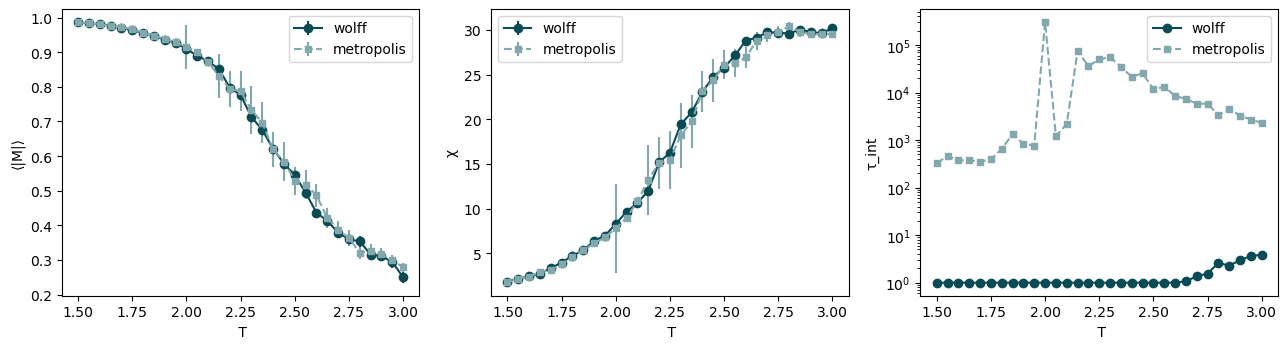

In [ ]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo


def run_one_method(method, temperatures, Lx, Ly, J, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = IsingLattice(Lx, Ly, J=J)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)

        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

temperatures = np.linspace(1.5, 3.0, 31)
Lx = 10; Ly = 10           
J_fm = -1.0                  

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, Lx, Ly, J_fm, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, Lx, Ly, J_fm, warmup_m, steps_m)



Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 2322.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3196.40it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3670.01it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3246.41it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3736.31it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 2938.41it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3403.20it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3097.14it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3463.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3135.68it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3501.67it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3167.94it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3300.13it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 2996.46it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3739.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3394.10it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3693.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3352.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4035.74it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3481.42it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3931.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3519.48it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3783.12it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3577.40it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4206.21it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3709.17it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3985.24it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3778.79it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4264.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3912.55it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5130.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4425.92it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4919.89it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4832.36it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5730.16it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5128.62it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6116.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5634.04it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6500.38it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6093.27it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7451.64it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6505.00it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7309.19it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7414.07it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9171.69it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8175.01it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8394.65it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9184.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9849.48it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9576.52it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10164.31it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10555.51it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14710.66it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10676.44it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12194.87it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11697.77it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15159.95it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12444.34it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14756.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13013.62it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 17344.74it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14338.81it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108744.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39783.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106757.84it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40207.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 98793.44it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41086.77it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109101.68it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40110.54it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101121.83it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40062.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110967.82it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39684.67it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112006.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41841.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111548.41it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40153.34it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107188.41it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41116.06it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112250.89it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40603.59it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107177.57it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39568.48it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107568.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40743.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109644.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39867.06it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112810.36it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40153.12it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110088.63it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39962.50it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105562.52it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39935.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111863.26it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40638.62it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103796.85it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41990.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111629.28it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41781.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110602.52it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41026.38it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108976.47it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39837.14it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 116715.29it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40739.13it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111291.77it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41203.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103915.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41556.18it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106399.81it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40894.00it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109636.49it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40743.47it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 116144.27it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40794.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108394.60it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40834.80it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 91816.45it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40479.68it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106553.15it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41158.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105461.76it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40518.31it/s]


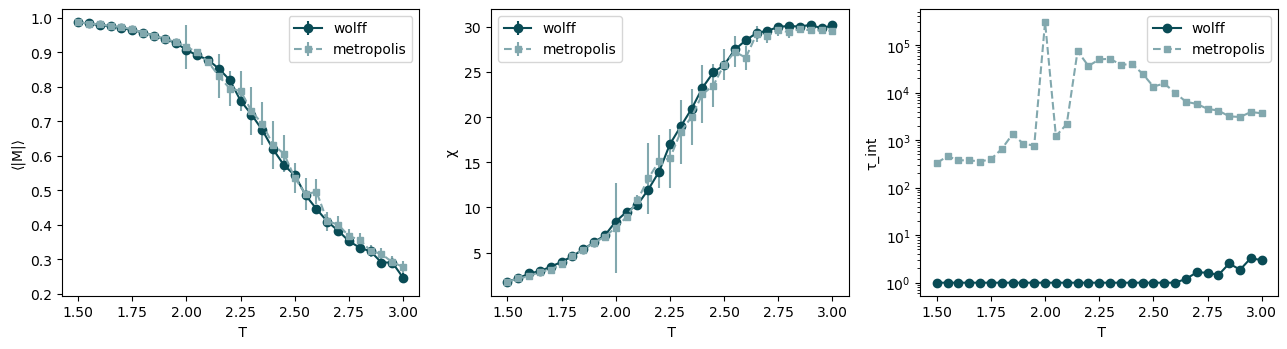

In [2]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lattice import Lattice
from monte_carlo import MonteCarlo
        

def run_one_method(method, temperatures, rows, cols, doping, kf, J0, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = Lattice(rows=rows,cols=cols,doping=doping,kf=kf,J0=J0)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)

        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

temperatures = np.linspace(1., 5.0, 31)
rows, cols = 10, 10
doping = 0.3
kf = 0.3
J0 = -1               

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, rows, cols, doping, kf, J0, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, rows, cols, doping, kf, J0, warmup_m, steps_m)

